![](dectree.jpg)

# 1. Introduction 

In [Part 1](https://tonyjustdevs.github.io/blog/posts/2024-04-24-one_r_classifier/), a simple model was built using single binary split called `OneR Classifier`.  

- Actually the split chosen is considered the `best single binary split` for each column in the dataset. 
    - `Best` implying the split seperates the survived and perished the best amongst all the split points available.  
- By creating binary splits recursively (binary splits on the binary splits), `Decision Trees` are built.
    - For example, if we split the dataset to male and female, each of these can be split by another column such as 'Age' or 'PClass'.
- By increasing the number leaf nodes , `Loss` is reduced, thus an improvement on the OneR Classifier.

# 2. Binary Split 'Sex' Column

In [1]:
from fastai.imports import *
import torch, numpy as np, pandas as pd
import kaggle, zipfile
from pathlib import Path
path = Path("titanic")
if not path.exists():
    print(f"{path} folder doesn't exist, downloading...")
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f"{path}.zip").extractall(path)
else:
    print(f"{path} exists!")
!ls {path}

def proc_data_1(df):
    modes           = df.mode().iloc[0]
    df['Fare']      = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare']   = np.log1p(df['Fare'])
    df['Embarked']  = pd.Categorical(df.Embarked)
    df['Sex']       = pd.Categorical(df.Sex)

def convert_cats_to_codes_2(trn_df, val_df, cat_list):
    trn_df[cat_list] = trn_df[cat_list].apply(lambda dfcol: dfcol.cat.codes) # replace with 1 and 0s
    val_df[cat_list] = val_df[cat_list].apply(lambda dfcol: dfcol.cat.codes)
    return trn_df, val_df

from numpy import random
from sklearn.model_selection import train_test_split
random.seed(42)

# 0 get raw data
df              = pd.read_csv(path/'train.csv')
tst_df          = pd.read_csv(path/'test.csv')
# 1. clean data ([replace nas with mode], [logfare], [sex/embarked to cat])
proc_data_1(df)
proc_data_1(tst_df)

# 2. split training data: training and validation set
trn_df,val_df   = train_test_split(df, test_size=0.25)

# 3. convert cats to codes
cat_list        = ["Sex","Embarked"]
trn_df, val_df  = convert_cats_to_codes_2(trn_df, val_df, cat_list)

# 4. get idep and deps
dep_col         = "Survived"
cont_list       = ['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
def get_trn_and_val_idep_dep(df):
    idep    = df[ cat_list + cont_list ].copy()
    dep     = df[dep_col]
    return idep, dep

trn_idep,trn_dep = get_trn_and_val_idep_dep(trn_df)
val_idep,val_dep = get_trn_and_val_idep_dep(val_df)

all_cols = cat_list+cont_list 
all_cols.remove("Sex")
ismale = trn_df.Sex==1
trn_males,trn_females = trn_df[ismale],trn_df[~ismale]

titanic exists!
gender_submission.csv  test.csv  train.csv


In [2]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

def score(idep_col, dep, split_val):
    lhs_bool_list = idep_col <= split_val
    return (_side_score(lhs_bool_list, dep) + _side_score(~lhs_bool_list, dep)) / len(dep)

def calc_best_bin_split_per_col(df, idep_col_name):
    idep_col    = df[idep_col_name]
    dep         = df[dep_col]

    col_uniques = idep_col.dropna().unique() # get all unique values of idep col
    
    scores = np.array( # get score for each unique value in idep_col
        [score(idep_col, dep, col_val) 
         for col_val in col_uniques 
         if not np.isnan(col_val)
         ])
    
    idx = scores.argmin() # get index of min score
    return col_uniques[idx],scores[idx]

# 3. Run 1R Classifier (best binary split) on each training set


## 3.1 Male Training Set

In [3]:
{col_name:calc_best_bin_split_per_col(trn_males, col_name) for col_name in all_cols}


{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

## 3.2 Female Training Set


In [4]:
{col_name:calc_best_bin_split_per_col(trn_females, col_name) for col_name in all_cols}


{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

# 4. Decision Tree

The above results showing best split for `males` is:    
- `Age<=6`   

and best split for `females` is:  
- `Pclass<=2`

These extra rules means a `decision tree` model has been created.

This model will:  
1. Check `Sex` is male or female then  
2. Check `Age<=6` or `Pclass<=2` where appropriate, then make the `prediction`.

By repeating the process, more additional rules can be created for each of 4 groups just created.   
This can be manually, or we can use a framework from `sklearn`, the model is called `DecisionTreeClassifier`

# 5. sklearn.tree: DecisionTreeClassifier
Using sklearn module, we can use `DecisionTreeClassifier` module to build our decision tree.

## 5.1 Max 4 nodes
Start with maximum 4 nodes.

In [5]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m_DecTree_max4nodes = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_idep, trn_dep)

In [6]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

## 5.2 Draw the Decision Tree with 4 nodes

The model applied 1R to two levels and determined the same splits I did. 
Graph terminology:
- `colour`: Blue is high survival rate, Orange is low survival rate.
- `samples`: rows matching the set of rules 
- `values`: how many survived or perished, hence two values. 
- `gini`: measure of impurity, 1 means the whole group is the same, 0 means all rows are different 


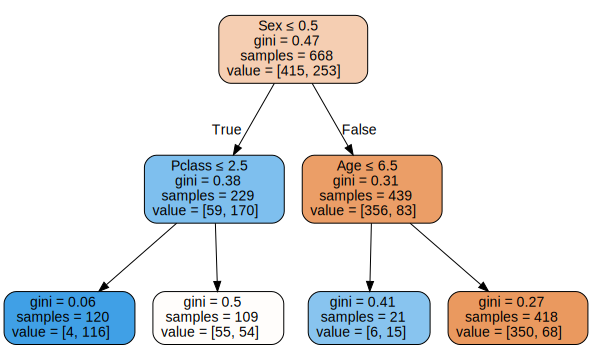

In [7]:
draw_tree(m_DecTree_max4nodes, trn_idep, size=10)

### 5.2.1 Loss (DTree, max 4 leaf nodes)

**MAE 22.4%**


In [8]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_dep, m_DecTree_max4nodes.predict(val_idep))

0.2242152466367713

## 5.3 Decision Tree with minimum 50 leaf nodes

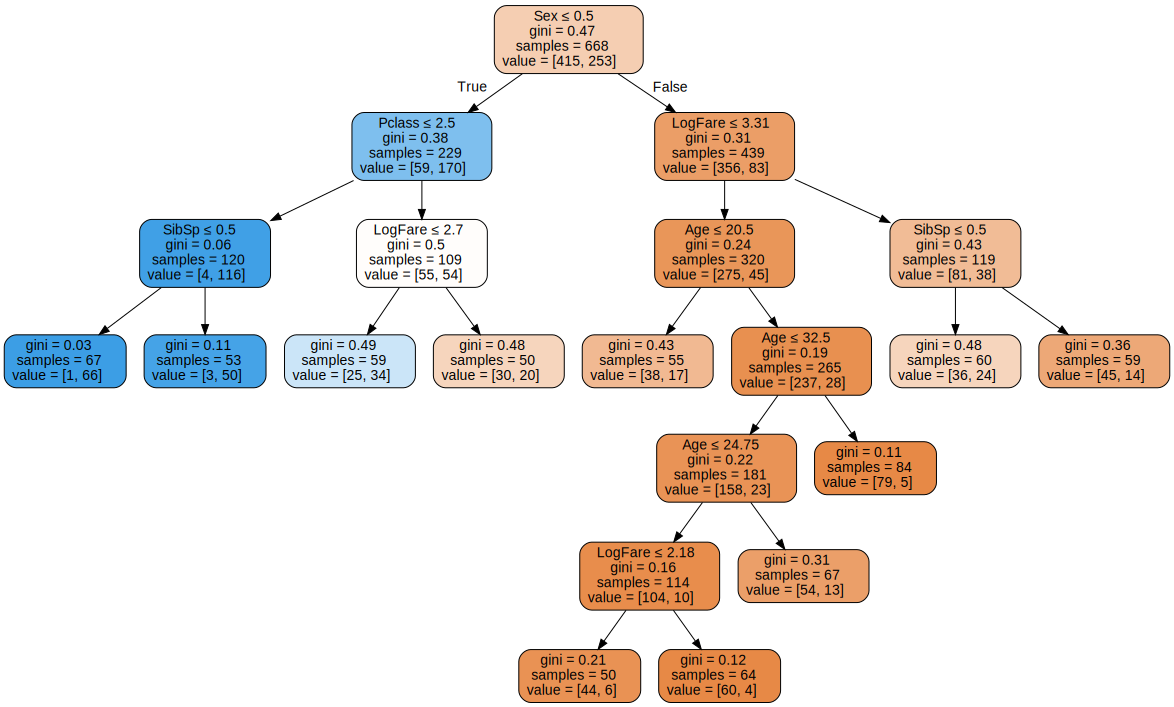

In [9]:
m_DecTree_min50nodes = DecisionTreeClassifier(min_samples_leaf=50)
m_DecTree_min50nodes.fit(trn_idep, trn_dep)
draw_tree(m_DecTree_min50nodes, trn_idep, size=25)

### 5.3.1 Loss (DTree, min 50 leaf nodes)

**MAE 18.4%** (previous model 22.4%)

In [10]:
mean_absolute_error(val_dep, m_DecTree_min50nodes.predict(val_idep))


0.18385650224215247

# 6. Decision Tree Completed  

- In this post I showed how to build a `simple decision tree with 4 nodes` from scratch.  

- I then use the `sklearn` framework, and to do the same and drew the tree out with their drawing functionality, achieving the same splits.  

- Finally, I increased the `minimum leaf nodes to 50` and saw substantial decrease in the `loss` from `22.4% to 18.4%`